#                                        # Jupyter Notebook - Churners Model 

In [1]:
#https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
#https://towardsdatascience.com/end-to-end-python-framework-for-predictive-modeling-b8052bb96a78
%matplotlib inline
import datetime as dt
import pyodbc 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# data colelction and preprocessing
from bs4 import BeautifulSoup
import requests
import pandas as pd
import csv
# for data visualisation and statistical analysis
import numpy as np
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-HE1PKJF;'
                      'Database=AdventureWorksDW2016;'
                      'Trusted_Connection=yes;')

In [3]:
#Import Factinternetsales from AHG SQL Datawarehouse
df_internet = pd.read_sql_query("""
SELECT
[CustomerKey]
,[OrderQuantity]
,[SalesAmount]
,[OrderDate]
,[SalesTerritoryKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", conn)

In [4]:
df_c=pd.read_sql_query("""
SELECT
[CustomerKey]
,[BirthDate]
,[MaritalStatus]
,[Gender]
,[YearlyIncome]
,[TotalChildren]
,[NumberChildrenAtHome]
,[EnglishEducation]
,[EnglishOccupation]
,[HouseOwnerFlag]
,[NumberCarsOwned]
,[DateFirstPurchase]
,[CommuteDistance]
FROM [dbo].[DimCustomer]""", conn)

#add df_final from rfm to here

In [5]:
df_rfm=pd.read_excel('RFM_Outcome.xlsx')

In [6]:
df_customer=pd.merge(df_c,df_rfm,on='CustomerKey')

In [7]:
df_customer.columns

Index(['CustomerKey', 'BirthDate', 'MaritalStatus_x', 'Gender_x',
       'YearlyIncome_x', 'TotalChildren_x', 'NumberChildrenAtHome_x',
       'EnglishEducation_x', 'EnglishOccupation_x', 'HouseOwnerFlag_x',
       'NumberCarsOwned_x', 'DateFirstPurchase', 'CommuteDistance_x',
       'Unnamed: 0', 'EnglishEducation_y', 'CommuteDistance_y',
       'EnglishOccupation_y', 'Gender_y', 'HouseOwnerFlag_y',
       'MaritalStatus_y', 'NumberCarsOwned_y', 'NumberChildrenAtHome_y',
       'TotalChildren_y', 'YearlyIncome_y', 'Age', 'RFMGroup', 'RFMScore',
       'RFM_Loyalty_Level', 'Cluster'],
      dtype='object')

In [8]:
df_customer=df_customer.drop(columns=['Unnamed: 0','EnglishEducation_y','CommuteDistance_y','EnglishOccupation_y', 'Gender_y', 'HouseOwnerFlag_y','MaritalStatus_y', 'NumberCarsOwned_y', 'NumberChildrenAtHome_y',
       'TotalChildren_y', 'YearlyIncome_y','RFMGroup', 'RFMScore','RFM_Loyalty_Level'],axis=1)

In [9]:
df_customer.columns

Index(['CustomerKey', 'BirthDate', 'MaritalStatus_x', 'Gender_x',
       'YearlyIncome_x', 'TotalChildren_x', 'NumberChildrenAtHome_x',
       'EnglishEducation_x', 'EnglishOccupation_x', 'HouseOwnerFlag_x',
       'NumberCarsOwned_x', 'DateFirstPurchase', 'CommuteDistance_x', 'Age',
       'Cluster'],
      dtype='object')

In [10]:
df_customer = df_customer.rename(columns = {'MaritalStatus_x':'MaritalStatus','Gender_x':'Gender','YearlyIncome_x':'YearlyIncome','TotalChildren_x':'TotalChildren','NumberChildrenAtHome_x':'NumberChildrenAtHome','EnglishEducation_x':'EnglishEducation','EnglishOccupation_x':'EnglishOccupation','HouseOwnerFlag_x':'HouseOwnerFlag','NumberCarsOwned_x':'NumberCarsOwned','CommuteDistance_x':'CommuteDistance'})

In [11]:
df_customer.columns

Index(['CustomerKey', 'BirthDate', 'MaritalStatus', 'Gender', 'YearlyIncome',
       'TotalChildren', 'NumberChildrenAtHome', 'EnglishEducation',
       'EnglishOccupation', 'HouseOwnerFlag', 'NumberCarsOwned',
       'DateFirstPurchase', 'CommuteDistance', 'Age', 'Cluster'],
      dtype='object')

In [12]:
df_customer=df_customer.drop(columns=['Age'],axis=1)

In [13]:
df_fact_sales_reason = pd.read_sql_query("""
SELECT *
FROM [dbo].[FactInternetSalesReason]""", conn)

In [14]:
df_salesreason = pd.read_sql_query("""
SELECT *
FROM [dbo].[DimSalesReason]""", conn)

In [15]:
df_internet.head()

,CustomerKey,OrderQuantity,SalesAmount,OrderDate,SalesTerritoryKey,SalesOrderNumber
0,21768,1,3578.2700,2010-12-29,6,SO43697
1,28389,1,3399.9900,2010-12-29,7,SO43698
2,25863,1,3399.9900,2010-12-29,1,SO43699
3,14501,1,699.0982,2010-12-29,4,SO43700
4,11003,1,3399.9900,2010-12-29,9,SO43701


change order of variables

In [16]:
internet_sales = df_internet
internet_sales = internet_sales[['SalesOrderNumber','CustomerKey','OrderDate','SalesAmount','OrderQuantity']]

In [17]:
internet_sales.tail()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity
60393,SO75122,15868,2014-01-28,21.98,1
60394,SO75122,15868,2014-01-28,8.99,1
60395,SO75123,18759,2014-01-28,21.98,1
60396,SO75123,18759,2014-01-28,159.00,1
60397,SO75123,18759,2014-01-28,8.99,1


In [18]:
internet_sales = internet_sales.groupby(['SalesOrderNumber','CustomerKey','OrderDate']).agg({'SalesAmount':'sum', 
                         'OrderQuantity':'sum'})

In [19]:
internet_sales.tail()

,,,SalesAmount,OrderQuantity
SalesOrderNumber,CustomerKey,OrderDate,,
SO75119,11981,2014-01-28,42.28,3
SO75120,18749,2014-01-28,84.96,3
SO75121,15251,2014-01-28,74.98,3
SO75122,15868,2014-01-28,30.97,2
SO75123,18759,2014-01-28,189.97,3


internet_sales[internet_sales['CustomerKey'] == 11000], cannot be performed as the new aggregated fields
have not been combined to the rest of the dataset

In [20]:
internet_sales.columns

Index(['SalesAmount', 'OrderQuantity'], dtype='object')

In [21]:
internet_sales.columns = internet_sales.columns.ravel()

In [22]:
#Reset the index
internet_sales = internet_sales.reset_index()

Now the coloumns are linked you can view any customer info

In [23]:
internet_sales[internet_sales['CustomerKey'] == 11000]

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity
96,SO43793,11000,2011-01-19,3399.99,1
5774,SO51522,11000,2013-01-18,2341.97,2
11030,SO57418,11000,2013-05-03,2507.03,5


sort dataset by customerkey and orderdate

In [24]:
internet_sales.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity
96,SO43793,11000,2011-01-19,3399.99,1
5774,SO51522,11000,2013-01-18,2341.97,2
11030,SO57418,11000,2013-05-03,2507.03,5
70,SO43767,11001,2011-01-15,3374.99,1
5745,SO51493,11001,2013-01-16,2419.93,6


create a new coloumn with the number of days between each purchase for every customer

In [25]:
internet_sales['days_btw_purchase']=internet_sales.sort_values(['CustomerKey','OrderDate']).groupby('CustomerKey')['OrderDate'].diff()

In [26]:
internet_sales.head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,days_btw_purchase
0,SO43697,21768,2010-12-29,3578.2700,1,NaT
1,SO43698,28389,2010-12-29,3399.9900,1,NaT
2,SO43699,25863,2010-12-29,3399.9900,1,NaT
3,SO43700,14501,2010-12-29,699.0982,1,NaT
4,SO43701,11003,2010-12-29,3399.9900,1,NaT


In [27]:
internet_sales.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,days_btw_purchase
96,SO43793,11000,2011-01-19,3399.99,1,NaT
5774,SO51522,11000,2013-01-18,2341.97,2,730 days
11030,SO57418,11000,2013-05-03,2507.03,5,105 days
70,SO43767,11001,2011-01-15,3374.99,1,NaT
5745,SO51493,11001,2013-01-16,2419.93,6,732 days


In [28]:
internet_sales['days_btw_purchase'] = internet_sales['days_btw_purchase'].astype('timedelta64[D]')

In [29]:
internet_sales.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,days_btw_purchase
96,SO43793,11000,2011-01-19,3399.99,1,NaN
5774,SO51522,11000,2013-01-18,2341.97,2,730.0
11030,SO57418,11000,2013-05-03,2507.03,5,105.0
70,SO43767,11001,2011-01-15,3374.99,1,NaN
5745,SO51493,11001,2013-01-16,2419.93,6,732.0


In [30]:
internet_sales.dtypes

SalesOrderNumber             object
CustomerKey                   int64
OrderDate            datetime64[ns]
SalesAmount                 float64
OrderQuantity                 int64
days_btw_purchase           float64
dtype: object

In [31]:
internet_sales['days_btw_purchase']=internet_sales['days_btw_purchase'].fillna(0).astype(int)

In [32]:
internet_sales.sort_values(['CustomerKey','OrderDate']).head()

,SalesOrderNumber,CustomerKey,OrderDate,SalesAmount,OrderQuantity,days_btw_purchase
96,SO43793,11000,2011-01-19,3399.99,1,0
5774,SO51522,11000,2013-01-18,2341.97,2,730
11030,SO57418,11000,2013-05-03,2507.03,5,105
70,SO43767,11001,2011-01-15,3374.99,1,0
5745,SO51493,11001,2013-01-16,2419.93,6,732


get insights into the data coloumns

In [33]:
new_internet_sales=internet_sales.groupby('CustomerKey').agg({'SalesAmount':['sum','max','min','mean','median'],
                                                              'OrderQuantity':['sum','max','min','mean','median'],
                                                              'OrderDate':'max',
                                                              'days_btw_purchase':['sum','max','min','mean','median']
                                                             })

In [34]:
new_internet_sales.head()

SalesAmount                                         OrderQuantity  \
                    sum      max      min         mean   median           sum   
CustomerKey                                                                     
11000           8248.99  3399.99  2341.97  2749.663333  2507.03             8   
11001           6383.88  3374.99   588.96  2127.960000  2419.93            11   
11002           8114.04  3399.99  2294.99  2704.680000  2419.06             4   
11003           8139.29  3399.99  2318.96  2713.096667  2420.34             9   
11004           8196.01  3399.99  2376.96  2732.003333  2419.06             6   

                                      OrderDate days_btw_purchase           \
            max min      mean median        max               sum  max min   
CustomerKey                                                                  
11000         5   1  2.666667    2.0 2013-05-03               835  730   0   
11001         6   1  3.666667    4.0 2013-12-10              1060  732   0   
11002         2   1  1.333333    1.0 2013-02-23               778  724   0   
11003         4   1  3.000000    4.0 2013-05-10               863  738   0   
11004         3   1  2.000000    2.0 2013-05-01               829  730   0   

                                
                   mean median  
CustomerKey                     
11000        278.333333  105.0  
11001        353.333333  328.0  
11002        259.333333   54.0  
11003        287.666667  125.0  
11004        276.333333   99.0

new_internet_sales[new_internet_sales['CustomerKey'] == 11000], need to join the new aggregated fields

In [35]:
new_internet_sales.columns

MultiIndex([(      'SalesAmount',    'sum'),
            (      'SalesAmount',    'max'),
            (      'SalesAmount',    'min'),
            (      'SalesAmount',   'mean'),
            (      'SalesAmount', 'median'),
            (    'OrderQuantity',    'sum'),
            (    'OrderQuantity',    'max'),
            (    'OrderQuantity',    'min'),
            (    'OrderQuantity',   'mean'),
            (    'OrderQuantity', 'median'),
            (        'OrderDate',    'max'),
            ('days_btw_purchase',    'sum'),
            ('days_btw_purchase',    'max'),
            ('days_btw_purchase',    'min'),
            ('days_btw_purchase',   'mean'),
            ('days_btw_purchase', 'median')],
           )

In [36]:
#Join the field names to the newly aggregate fields names
new_internet_sales.columns = ["_".join(new_internet_sales) for new_internet_sales in new_internet_sales.columns.ravel()]

In [37]:
new_internet_sales=new_internet_sales.reset_index()

In [38]:
new_internet_sales.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,OrderDate_max,days_btw_purchase_sum,days_btw_purchase_max,days_btw_purchase_min,days_btw_purchase_mean,days_btw_purchase_median
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,2.0,2013-05-03,835,730,0,278.333333,105.0
1,11001,6383.88,3374.99,588.96,2127.960000,2419.93,11,6,1,3.666667,4.0,2013-12-10,1060,732,0,353.333333,328.0
2,11002,8114.04,3399.99,2294.99,2704.680000,2419.06,4,2,1,1.333333,1.0,2013-02-23,778,724,0,259.333333,54.0
3,11003,8139.29,3399.99,2318.96,2713.096667,2420.34,9,4,1,3.000000,4.0,2013-05-10,863,738,0,287.666667,125.0
4,11004,8196.01,3399.99,2376.96,2732.003333,2419.06,6,3,1,2.000000,2.0,2013-05-01,829,730,0,276.333333,99.0


We can now merge the dataset with the costomers dataset

In [39]:
df=pd.merge(new_internet_sales,df_customer,on='CustomerKey')

In [40]:
df.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Cluster
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles,0
1,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles,0
2,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles,0
3,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles,0
4,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles,0


merge Salesreason data

In [41]:
df_sales = pd.merge(df_fact_sales_reason,df_salesreason,on='SalesReasonKey')
df_sales.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other


In [42]:
df_sales.sort_values(['SalesOrderNumber']).head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1818,SO43697,1,9,9,Quality,Other
1819,SO43702,1,9,9,Quality,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other


get the dummy variables for SalesReasonName

In [43]:
reason_dummy=pd.get_dummies(df_sales.SalesReasonName,columns=['Price', 'On Promotion', 'Magazine Advertisement','TV', 'Manufacturer', 'Review','Demo Event', 'Sponsorship', 'Quality', 'Other'])

In [44]:
df_sales=pd.concat([df_sales,reason_dummy],axis=1)

In [45]:
df_sales.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [46]:
df_sales.sort_values(['SalesOrderNumber']).head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1818,SO43697,1,9,9,Quality,Other,0,0,0,0,1,0,0
1819,SO43702,1,9,9,Quality,Other,0,0,0,0,1,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


show unique salesreason name

In [47]:
df_sales.SalesReasonName.unique()

array(['Manufacturer', 'Quality', 'On Promotion', 'Review', 'Price',
       'Other', 'Television  Advertisement'], dtype=object)

In [48]:
fctintsales = pd.read_sql_query("""
SELECT
[CustomerKey]
,[SalesOrderNumber]
FROM [dbo].[FactInternetSales]""", conn)

In [49]:
fctintsales.head()

,CustomerKey,SalesOrderNumber
0,21768,SO43697
1,28389,SO43698
2,25863,SO43699
3,14501,SO43700
4,11003,SO43701


merge fctinternet with df_sales

In [50]:
df_sales=pd.merge(fctintsales,df_sales, on='SalesOrderNumber')

In [51]:
df_sales.head()

,CustomerKey,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,21768,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,21768,SO43697,1,9,9,Quality,Other,0,0,0,0,1,0,0
2,27645,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,27645,SO43702,1,9,9,Quality,Other,0,0,0,0,1,0,0
4,16624,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [52]:
df_sales=df_sales.groupby('CustomerKey').agg({
    'Manufacturer':'max', 
                         'On Promotion':'max', 
                         'Other':'max',
                          'Price':'max',
                            'Quality':'max',
                              'Review':'max',
                                'Television  Advertisement':'max'}).reset_index()

In [53]:
df_sales.head()

,CustomerKey,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [54]:
#left join main data back to summarise sales reason data
df_final = pd.merge(df,
                 df_sales,
                 on='CustomerKey', how='left')

In [55]:
df_final.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,DateFirstPurchase,CommuteDistance,Cluster,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,2011-01-19,1-2 Miles,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,2011-01-19,1-2 Miles,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,2011-01-19,1-2 Miles,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,2011-01-19,1-2 Miles,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,2011-01-19,1-2 Miles,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


derive AGe

In [56]:
df_final.dtypes

CustomerKey                           int64
SalesAmount_sum                     float64
SalesAmount_max                     float64
SalesAmount_min                     float64
SalesAmount_mean                    float64
SalesAmount_median                  float64
OrderQuantity_sum                     int64
OrderQuantity_max                     int64
OrderQuantity_min                     int64
OrderQuantity_mean                  float64
OrderQuantity_median                float64
OrderDate_max                datetime64[ns]
days_btw_purchase_sum                 int32
days_btw_purchase_max                 int32
days_btw_purchase_min                 int32
days_btw_purchase_mean              float64
days_btw_purchase_median            float64
BirthDate                            object
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome            

In [57]:
df_final['BirthDate']=pd.to_datetime(df_final['BirthDate'])

In [58]:
df_final['Age_years'] = ((df_final['OrderDate_max'].dt.date -  df_final['BirthDate'].dt.date)/np.timedelta64(1, 'Y')).astype(int)

Derive the tenure

In [59]:
df_final['DateFirstPurchase']=pd.to_datetime(df_final['DateFirstPurchase'])

In [60]:
df_final['Tenure_Months'] = ((df_final['OrderDate_max'].dt.date -  df_final['DateFirstPurchase'].dt.date)/np.timedelta64(1, 'M')).astype(int)

In [61]:
df_final.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Cluster,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Age_years,Tenure_Months
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27
1,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27
2,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27
3,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27
4,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27


Last purchase made on

In [62]:
df_final['Last_purchase_date'] = df_final['OrderDate_max'].dt.date

In [63]:
df_final.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,Age_years,Tenure_Months,Last_purchase_date
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03
1,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03
2,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03
3,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03
4,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03


last orderdate

In [64]:
df_final.OrderDate_max.max()

Timestamp('2014-01-28 00:00:00')

cut off date will be last order date - 5 months

In [65]:
df_final['Cuttoff_date'] = '2013-07-28'

In [66]:
df_final.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,On Promotion,Other,Price,Quality,Review,Television Advertisement,Age_years,Tenure_Months,Last_purchase_date,Cuttoff_date
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28
1,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28
2,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28
3,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28
4,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,1.0,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28


In [67]:
df_final.dtypes

CustomerKey                           int64
SalesAmount_sum                     float64
SalesAmount_max                     float64
SalesAmount_min                     float64
SalesAmount_mean                    float64
SalesAmount_median                  float64
OrderQuantity_sum                     int64
OrderQuantity_max                     int64
OrderQuantity_min                     int64
OrderQuantity_mean                  float64
OrderQuantity_median                float64
OrderDate_max                datetime64[ns]
days_btw_purchase_sum                 int32
days_btw_purchase_max                 int32
days_btw_purchase_min                 int32
days_btw_purchase_mean              float64
days_btw_purchase_median            float64
BirthDate                    datetime64[ns]
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome            

Convert dates from objects to date formats

In [68]:
df_final['Last_purchase_date'] = pd.to_datetime(df_final['Last_purchase_date'],format="%Y-%m-%d")
df_final['Cuttoff_date']=pd.to_datetime(df_final['Cuttoff_date'], format="%Y-%m-%d")

creating the target variable based on the cutoff date

In [69]:
df_final['Churn']=np.where(df_final['Last_purchase_date']<=df_final['Cuttoff_date'],1,0)

In [70]:
df_final.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,Other,Price,Quality,Review,Television Advertisement,Age_years,Tenure_Months,Last_purchase_date,Cuttoff_date,Churn
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28,1
1,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28,1
2,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28,1
3,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28,1
4,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0.0,1.0,0.0,0.0,0.0,41,27,2013-05-03,2013-07-28,1


now the dataset is complete, we can convert our categorical variables

In [71]:
df_final.dtypes

CustomerKey                           int64
SalesAmount_sum                     float64
SalesAmount_max                     float64
SalesAmount_min                     float64
SalesAmount_mean                    float64
SalesAmount_median                  float64
OrderQuantity_sum                     int64
OrderQuantity_max                     int64
OrderQuantity_min                     int64
OrderQuantity_mean                  float64
OrderQuantity_median                float64
OrderDate_max                datetime64[ns]
days_btw_purchase_sum                 int32
days_btw_purchase_max                 int32
days_btw_purchase_min                 int32
days_btw_purchase_mean              float64
days_btw_purchase_median            float64
BirthDate                    datetime64[ns]
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome            

In [72]:
df_final=pd.get_dummies(df_final,columns=['MaritalStatus','Gender','EnglishEducation','EnglishOccupation','HouseOwnerFlag','CommuteDistance'], drop_first = False)

In [73]:
df_final.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
0,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,1,0,0,1,0,1,0,0,0
1,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,1,0,0,1,0,1,0,0,0
2,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,1,0,0,1,0,1,0,0,0
3,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,1,0,0,1,0,1,0,0,0
4,11000,8248.99,3399.99,2341.97,2749.663333,2507.03,8,5,1,2.666667,...,0,1,0,0,1,0,1,0,0,0


In [74]:
df_final.columns

Index(['CustomerKey', 'SalesAmount_sum', 'SalesAmount_max', 'SalesAmount_min',
       'SalesAmount_mean', 'SalesAmount_median', 'OrderQuantity_sum',
       'OrderQuantity_max', 'OrderQuantity_min', 'OrderQuantity_mean',
       'OrderQuantity_median', 'OrderDate_max', 'days_btw_purchase_sum',
       'days_btw_purchase_max', 'days_btw_purchase_min',
       'days_btw_purchase_mean', 'days_btw_purchase_median', 'BirthDate',
       'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome',
       'NumberCarsOwned', 'DateFirstPurchase', 'Cluster', 'Manufacturer',
       'On Promotion', 'Other', 'Price', 'Quality', 'Review',
       'Television  Advertisement', 'Age_years', 'Tenure_Months',
       'Last_purchase_date', 'Cuttoff_date', 'Churn', 'MaritalStatus_M',
       'MaritalStatus_S', 'Gender_F', 'Gender_M', 'EnglishEducation_Bachelors',
       'EnglishEducation_Graduate Degree', 'EnglishEducation_High School',
       'EnglishEducation_Partial College',
       'EnglishEducation_Partial High S

looking for missing values in the dataset

In [75]:
print(df_final.isnull().any())

CustomerKey                             False
SalesAmount_sum                         False
SalesAmount_max                         False
SalesAmount_min                         False
SalesAmount_mean                        False
SalesAmount_median                      False
OrderQuantity_sum                       False
OrderQuantity_max                       False
OrderQuantity_min                       False
OrderQuantity_mean                      False
OrderQuantity_median                    False
OrderDate_max                           False
days_btw_purchase_sum                   False
days_btw_purchase_max                   False
days_btw_purchase_min                   False
days_btw_purchase_mean                  False
days_btw_purchase_median                False
BirthDate                               False
YearlyIncome                            False
TotalChildren                           False
NumberChildrenAtHome                    False
NumberCarsOwned                   

list all the variables with missing values

In [76]:
df_final.columns[df_final.isnull().any()].tolist()

['Manufacturer',
 'On Promotion',
 'Other',
 'Price',
 'Quality',
 'Review',
 'Television  Advertisement']

# Data Visulaisation

Text(0.5, 0, 'Yearly Income')

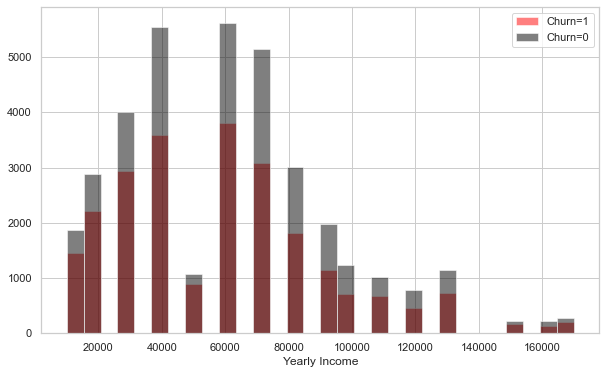

In [77]:
plt.figure(figsize=(10,6))
df_final[df_final['Churn']==1]['YearlyIncome'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=1')
df_final[df_final['Churn']==0]['YearlyIncome'].hist(alpha=0.5,color='black',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Yearly Income')

In [78]:
df_final['Churn'].value_counts()

0    36011
1    23979
Name: Churn, dtype: int64

In [194]:
df_final.columns

Index(['CustomerKey', 'SalesAmount_sum', 'SalesAmount_max', 'SalesAmount_min',
       'SalesAmount_mean', 'SalesAmount_median', 'OrderQuantity_sum',
       'OrderQuantity_max', 'OrderQuantity_min', 'OrderQuantity_mean',
       'OrderQuantity_median', 'OrderDate_max', 'days_btw_purchase_sum',
       'days_btw_purchase_max', 'days_btw_purchase_min',
       'days_btw_purchase_mean', 'days_btw_purchase_median', 'BirthDate',
       'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome',
       'NumberCarsOwned', 'DateFirstPurchase', 'Cluster', 'Manufacturer',
       'On Promotion', 'Other', 'Price', 'Quality', 'Review',
       'Television  Advertisement', 'Age_years', 'Tenure_Months',
       'Last_purchase_date', 'Cuttoff_date', 'Churn', 'MaritalStatus_M',
       'MaritalStatus_S', 'Gender_F', 'Gender_M', 'EnglishEducation_Bachelors',
       'EnglishEducation_Graduate Degree', 'EnglishEducation_High School',
       'EnglishEducation_Partial College',
       'EnglishEducation_Partial High S

extract a section of the dataset for deployment at a later stage

In [79]:
#Keep an hold out sample for scoring and deployment. 
#extract only churners
Churners = df_final.loc[df_final['Churn'] == 1] 
#Extract only first 6973 rows from Non churners
non_churners = df_final.loc[df_final['Churn'] == 0]
#Score_data = final_data.loc[final_data['Churn'] == 0].tail(6000)

nu. of churners in remaining dataset

In [80]:
Churners['Churn'].value_counts()

1    23979
Name: Churn, dtype: int64

non-churners count

In [81]:
#Counting non churners
non_churners['Churn'].value_counts()

0    36011
Name: Churn, dtype: int64

seperate the non-churners into two group 1)train/test/validate 2) scoring

In [82]:
# Randomly seperate the 12973 Non-Churners into 2 groups:
#   50% - Non_churners - for training, validating, and testing the model
#   50% - Score_data - for scoring the model
# Used the train_test_split functions to achieve random selection of the data
#This is not for model purposes or data partitioning, its only to split the data and select a hold out sample
Score_data,Non_churners = train_test_split(non_churners,test_size=0.5,random_state=42)

In [83]:
Non_churners['Churn'].value_counts()

0    18006
Name: Churn, dtype: int64

sample for scoring

In [84]:
Score_data['Churn'].value_counts()

0    18005
Name: Churn, dtype: int64

In [85]:
Score_data.head()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
31230,18518,2379.95,2379.95,2379.95,2379.950000,2379.950,4,4,4,4.000000,...,0,0,0,0,1,0,0,0,1,0
16854,14427,8451.26,3578.27,2398.05,2817.086667,2474.940,10,6,1,3.333333,...,0,1,0,0,1,0,0,0,0,1
47512,24373,27.77,27.77,27.77,27.770000,27.770,3,3,3,3.000000,...,0,1,0,0,1,0,0,0,1,0
51774,26014,4713.33,3399.99,1313.34,2356.665000,2356.665,4,3,1,2.000000,...,0,1,0,1,0,1,0,0,0,0
3060,11422,7075.27,3399.99,562.96,1768.817500,1556.160,10,4,1,2.500000,...,0,0,0,0,1,0,0,0,0,1


In [196]:
Score_data_sel.columns

Index(['CustomerKey', 'SalesAmount_sum', 'SalesAmount_max', 'SalesAmount_min',
       'SalesAmount_mean', 'SalesAmount_median', 'OrderQuantity_sum',
       'OrderQuantity_max', 'OrderQuantity_min', 'OrderQuantity_mean',
       'OrderQuantity_median', 'OrderDate_max', 'days_btw_purchase_sum',
       'days_btw_purchase_max', 'days_btw_purchase_min',
       'days_btw_purchase_mean', 'days_btw_purchase_median', 'BirthDate',
       'YearlyIncome', 'TotalChildren', 'NumberChildrenAtHome',
       'NumberCarsOwned', 'DateFirstPurchase', 'Cluster', 'Manufacturer',
       'On Promotion', 'Other', 'Price', 'Quality', 'Review',
       'Television  Advertisement', 'Age_years', 'Tenure_Months',
       'Last_purchase_date', 'Cuttoff_date', 'Churn', 'MaritalStatus_M',
       'MaritalStatus_S', 'Gender_F', 'Gender_M', 'EnglishEducation_Bachelors',
       'EnglishEducation_Graduate Degree', 'EnglishEducation_High School',
       'EnglishEducation_Partial College',
       'EnglishEducation_Partial High S

In [86]:
#create dataset combining Churners and non churners excluding the hold out sample for scoring
model_data = pd.concat([Churners, Non_churners],ignore_index=True)

In [87]:
model_data['Churn'].value_counts()

1    23979
0    18006
Name: Churn, dtype: int64

looking at the distribution of the target variable

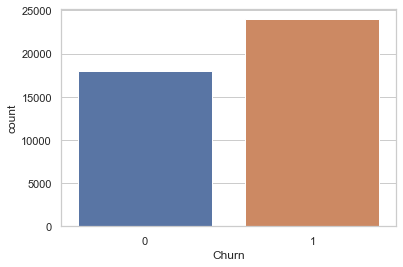

<Figure size 432x288 with 0 Axes>

In [88]:
#Display the distribution of the target variable - 0 = Non Churner - 1 = Churner
sns.countplot(x='Churn', data = model_data)
plt.show()
plt.savefig('count_plot')

looking the the difference in the mean for each variable against the target

In [89]:
model_data.groupby('Churn').mean()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
Churn,,,,,,,,,,,,,,,,,,,,,
0,18246.623348,2114.304706,1172.710789,752.518651,961.728521,963.445013,6.493502,3.174109,1.859769,2.490517,...,0.109352,0.325836,0.231478,0.302455,0.697545,0.351105,0.166445,0.139953,0.159891,0.182606
1,19739.832103,2048.367402,1320.037853,907.042925,1110.114436,1104.595062,3.669711,2.956295,2.047250,2.501571,...,0.124484,0.293966,0.245548,0.317361,0.682639,0.354352,0.173360,0.130739,0.173193,0.168356


look at age distribution

Text(0, 0.5, 'Frequency')

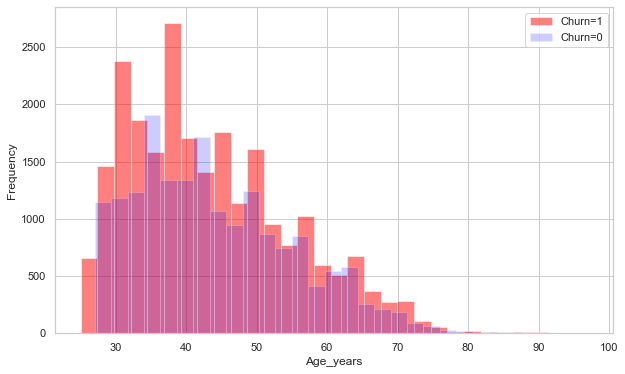

In [90]:
plt.figure(figsize=(10,6))
model_data[model_data['Churn']==1]['Age_years'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=1')
model_data[model_data['Churn']==0]['Age_years'].hist(alpha=0.2,color='blue',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Age_years')
plt.ylabel('Frequency')

Most of the customers in this dataset are in the age range of 30-40

Investigating Churn versus Tenure Months

Text(0, 0.5, 'Frequency')

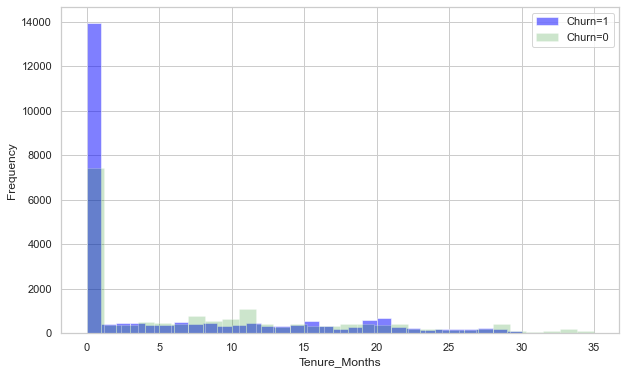

In [91]:
plt.figure(figsize=(10,6))
model_data[model_data['Churn']==1]['Tenure_Months'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
model_data[model_data['Churn']==0]['Tenure_Months'].hist(alpha=0.2,color='green',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('Tenure_Months')
plt.ylabel('Frequency')

Seems to be following the convention as the highest umber of churns a new customers less than one Month.

looking at the number of children vs target

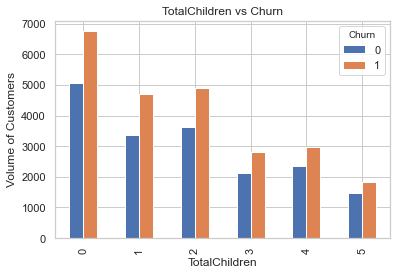

In [92]:
pd.crosstab(model_data.TotalChildren,model_data.Churn).plot(kind='bar')
plt.title('TotalChildren vs Churn')
plt.xlabel('TotalChildren')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

In [93]:
r=pd.crosstab(model_data.TotalChildren,model_data.Churn)

In [94]:
r

Churn,0,1
TotalChildren,,
0,5076,6761
1,3370,4704
2,3620,4899
3,2121,2820
4,2360,2972
5,1459,1823


identify variables with missing values in the dataset

In [95]:
model_data.isnull().any()

CustomerKey                             False
SalesAmount_sum                         False
SalesAmount_max                         False
SalesAmount_min                         False
SalesAmount_mean                        False
SalesAmount_median                      False
OrderQuantity_sum                       False
OrderQuantity_max                       False
OrderQuantity_min                       False
OrderQuantity_mean                      False
OrderQuantity_median                    False
OrderDate_max                           False
days_btw_purchase_sum                   False
days_btw_purchase_max                   False
days_btw_purchase_min                   False
days_btw_purchase_mean                  False
days_btw_purchase_median                False
BirthDate                               False
YearlyIncome                            False
TotalChildren                           False
NumberChildrenAtHome                    False
NumberCarsOwned                   

As the missing value variables are all categorical we can fill the missing values with the mode

In [96]:
model_data = model_data.fillna(model_data.mode().iloc[0])

look at the statistics of the dataset

In [97]:
model_data.describe()

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
count,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,...,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000,41985.000000
mean,19099.443468,2076.645765,1256.854070,840.772493,1046.476547,1044.060400,4.880743,3.049708,1.966845,2.496830,...,0.117995,0.307634,0.239514,0.310968,0.689032,0.352959,0.170394,0.134691,0.167488,0.174467
std,5454.327550,2482.193587,1305.843673,922.664018,1066.959648,1063.737422,6.591548,1.122300,1.152276,0.914242,...,0.322605,0.461520,0.426792,0.462895,0.462895,0.477896,0.375983,0.341397,0.373416,0.379515
min,11000.000000,2.290000,2.290000,2.290000,2.290000,2.290000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14176.000000,75.480000,68.970000,39.990000,56.970000,55.980000,3.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18680.000000,778.620000,614.980000,572.260000,614.980000,614.980000,4.000000,3.000000,2.000000,2.428571,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,23725.000000,3578.270000,2400.950000,1729.970000,2161.483333,2181.562500,5.000000,4.000000,3.000000,3.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,29483.000000,13295.380000,3578.270000,3578.270000,3578.270000,3578.270000,68.000000,8.000000,8.000000,8.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Selection

In [98]:
model_data.dtypes

CustomerKey                                      int64
SalesAmount_sum                                float64
SalesAmount_max                                float64
SalesAmount_min                                float64
SalesAmount_mean                               float64
SalesAmount_median                             float64
OrderQuantity_sum                                int64
OrderQuantity_max                                int64
OrderQuantity_min                                int64
OrderQuantity_mean                             float64
OrderQuantity_median                           float64
OrderDate_max                           datetime64[ns]
days_btw_purchase_sum                            int32
days_btw_purchase_max                            int32
days_btw_purchase_min                            int32
days_btw_purchase_mean                         float64
days_btw_purchase_median                       float64
BirthDate                               datetime64[ns]
YearlyInco

In [99]:
feat=model_data.drop(columns=['Churn','Cuttoff_date','Last_purchase_date','DateFirstPurchase','BirthDate','OrderDate_max','CustomerKey','SalesAmount_max','SalesAmount_min','SalesAmount_mean','SalesAmount_median'],axis=1)
label=model_data['Churn']

testing for feature importance and selection

In [100]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [101]:
final_iv, IV = data_vars(model_data[model_data.columns.difference(['Churn','CustomerKey','OrderDate_max','SalesAmount_max', 'SalesAmount_min','SalesAmount_mean', 'SalesAmount_median','OrderQuantity_min','OrderQuantity_max', 'OrderQuantity_mean', 'OrderQuantity_median','Cuttoff_date','Last_purchase_date','DateFirstPurchase','BirthDate'])],model_data.Churn)


In [102]:
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
1,Cluster,0.392340
27,OrderQuantity_sum,0.256005
34,Tenure_Months,0.144016
41,days_btw_purchase_sum,0.138061
37,days_btw_purchase_max,0.137415
38,days_btw_purchase_mean,0.134259
39,days_btw_purchase_median,0.129665
33,Television Advertisement,0.079544
30,Quality,0.039745
28,Other,0.036138


using random Forest

In [103]:
label.head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Churn, dtype: int32

In [104]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(feat,label)

preds = clf.predict(feat)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,label)
print(accuracy)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9975943789448612


In [105]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=feat.columns)

In [106]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
0,SalesAmount_sum,0.156435
15,Cluster,0.141399
23,Age_years,0.075098
6,days_btw_purchase_sum,0.061685
9,days_btw_purchase_mean,0.048190
7,days_btw_purchase_max,0.046778
11,YearlyIncome,0.045197
24,Tenure_Months,0.037783
10,days_btw_purchase_median,0.030599
1,OrderQuantity_sum,0.028493


Recursive Feature Elimination

In [107]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(feat, label)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

In [108]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=feat.columns)
Selected = Selected.reset_index()

In [109]:
Selected[Selected['RFE'] == True]

,index,RFE
1,OrderQuantity_sum,True
2,OrderQuantity_max,True
3,OrderQuantity_min,True
4,OrderQuantity_mean,True
15,Cluster,True
16,Manufacturer,True
17,On Promotion,True
18,Other,True
19,Price,True
20,Quality,True


Variable Importance using Extratrees Classifier

In [110]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(feat, label)

print(model.feature_importances_)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11481644 0.02599589 0.01579745 0.01253536 0.01646415 0.01590251
 0.03656383 0.03409595 0.         0.03071069 0.02687185 0.04278557
 0.03113731 0.02373501 0.02912973 0.13334721 0.01369993 0.01689929
 0.0112376  0.00625034 0.00919087 0.00774935 0.01110083 0.07029995
 0.05205467 0.01040506 0.01101594 0.01518797 0.01423093 0.01112897
 0.00964307 0.00894563 0.01114406 0.00515893 0.01019837 0.00795669
 0.00679717 0.01155267 0.00982694 0.01115535 0.01021204 0.01206062
 0.00908519 0.00765931 0.0093363  0.008927  ]


In [111]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=feat.columns)

In [112]:
FI = FI.reset_index()

In [113]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
15,Cluster,0.133347
0,SalesAmount_sum,0.114816
23,Age_years,0.070300
24,Tenure_Months,0.052055
11,YearlyIncome,0.042786
6,days_btw_purchase_sum,0.036564
7,days_btw_purchase_max,0.034096
12,TotalChildren,0.031137
9,days_btw_purchase_mean,0.030711
14,NumberCarsOwned,0.029130


Chi2

In [114]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(feat.abs(), label)

In [115]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=feat.columns)

In [116]:
chi_sq = chi_sq.reset_index()

In [117]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
11,YearlyIncome,681939.87
6,days_btw_purchase_sum,407160.70
7,days_btw_purchase_max,199499.54
9,days_btw_purchase_mean,83223.72
10,days_btw_purchase_median,63003.62
0,SalesAmount_sum,21530.50
1,OrderQuantity_sum,16800.93
24,Tenure_Months,13014.37
15,Cluster,890.41
22,Television Advertisement,743.73


L1

In [118]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(feat, label)
model = SelectFromModel(lsvc,prefit=True)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [119]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=feat.columns)
l1 = l1.reset_index()

In [120]:
l1[l1['L1'] == True]

,index,L1
0,SalesAmount_sum,True
1,OrderQuantity_sum,True
2,OrderQuantity_max,True
3,OrderQuantity_min,True
5,OrderQuantity_median,True
6,days_btw_purchase_sum,True
7,days_btw_purchase_max,True
9,days_btw_purchase_mean,True
10,days_btw_purchase_median,True
13,NumberChildrenAtHome,True


Combine all together

In [121]:
from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [122]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [123]:
score_table['final_score'] = score_table.sum(axis=1)

In [124]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
1,Cluster,1,1,1,0,1,1,5
41,days_btw_purchase_sum,1,1,0,1,0,1,4
38,days_btw_purchase_mean,0,1,0,1,0,1,3
37,days_btw_purchase_max,1,0,0,1,0,1,3
34,Tenure_Months,1,0,1,0,0,1,3
32,SalesAmount_sum,0,1,1,0,0,1,3
27,OrderQuantity_sum,1,0,0,0,1,1,3
0,Age_years,0,1,1,0,0,1,3
8,EnglishEducation_Graduate Degree,0,0,0,0,1,1,2
7,EnglishEducation_Bachelors,0,0,0,0,1,1,2


Using get_dummies introduces multicolineraity into the categorical variables

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [126]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [127]:
features = feat[list(score_table[score_table['final_score'] >= 2]['index'])]

In [128]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [129]:
list(vif['Features'])

['Cluster',
 'EnglishEducation_Bachelors',
 'EnglishEducation_Graduate Degree',
 'HouseOwnerFlag_0',
 'MaritalStatus_S',
 'On Promotion',
 'OrderQuantity_sum',
 'Other',
 'Price',
 'Quality',
 'Review',
 'SalesAmount_sum',
 'Television  Advertisement',
 'YearlyIncome',
 'days_btw_purchase_median']

In [130]:
feat.describe()

,SalesAmount_sum,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,OrderQuantity_median,days_btw_purchase_sum,days_btw_purchase_max,days_btw_purchase_min,days_btw_purchase_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
count,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,...,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00
mean,2076.65,4.88,3.05,1.97,2.50,2.49,211.41,192.02,0.00,90.91,...,0.12,0.31,0.24,0.31,0.69,0.35,0.17,0.13,0.17,0.17
std,2482.19,6.59,1.12,1.15,0.91,0.95,274.89,259.35,0.00,123.99,...,0.32,0.46,0.43,0.46,0.46,0.48,0.38,0.34,0.37,0.38
min,2.29,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,75.48,3.00,2.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,778.62,4.00,3.00,2.00,2.43,2.00,26.00,25.00,0.00,12.19,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
75%,3578.27,5.00,4.00,3.00,3.00,3.00,378.00,355.00,0.00,169.50,...,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00
max,13295.38,68.00,8.00,8.00,8.00,8.00,1089.00,1089.00,0.00,544.50,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [131]:
features.describe()

,Cluster,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,HouseOwnerFlag_0,MaritalStatus_S,On Promotion,OrderQuantity_sum,Other,Price,Quality,Review,SalesAmount_sum,Television Advertisement,YearlyIncome,days_btw_purchase_median
count,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00
mean,0.73,0.30,0.18,0.31,0.45,0.20,4.88,0.10,0.91,0.11,0.07,2076.65,0.04,59262.12,82.52
std,0.89,0.46,0.38,0.46,0.50,0.40,6.59,0.30,0.28,0.31,0.25,2482.19,0.20,33066.04,120.15
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.29,0.00,10000.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,1.00,0.00,0.00,75.48,0.00,30000.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,1.00,0.00,0.00,778.62,0.00,60000.00,6.00
75%,2.00,1.00,0.00,1.00,1.00,0.00,5.00,0.00,1.00,0.00,0.00,3578.27,0.00,80000.00,140.00
max,2.00,1.00,1.00,1.00,1.00,1.00,68.00,1.00,1.00,1.00,1.00,13295.38,1.00,170000.00,544.50


In [132]:
features.head(5)

,Cluster,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,HouseOwnerFlag_0,MaritalStatus_S,On Promotion,OrderQuantity_sum,Other,Price,Quality,Review,SalesAmount_sum,Television Advertisement,YearlyIncome,days_btw_purchase_median
0,0,1,0,0,0,1.00,8,0.00,1.00,0.00,0.00,8248.99,0.00,90000.00,105.00
1,0,1,0,0,0,1.00,8,0.00,1.00,0.00,0.00,8248.99,0.00,90000.00,105.00
2,0,1,0,0,0,1.00,8,0.00,1.00,0.00,0.00,8248.99,0.00,90000.00,105.00
3,0,1,0,0,0,1.00,8,0.00,1.00,0.00,0.00,8248.99,0.00,90000.00,105.00
4,0,1,0,0,0,1.00,8,0.00,1.00,0.00,0.00,8248.99,0.00,90000.00,105.00


Selected variables 

In [133]:
#Merge the best list to churn variable
final_vars = list(vif['Features']) + ['Churn']

In [134]:
df1 = model_data[final_vars].fillna(0)

In [135]:
df1.describe()

,Cluster,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,HouseOwnerFlag_0,MaritalStatus_S,On Promotion,OrderQuantity_sum,Other,Price,Quality,Review,SalesAmount_sum,Television Advertisement,YearlyIncome,days_btw_purchase_median,Churn
count,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00,41985.00
mean,0.73,0.30,0.18,0.31,0.45,0.20,4.88,0.10,0.91,0.11,0.07,2076.65,0.04,59262.12,82.52,0.57
std,0.89,0.46,0.38,0.46,0.50,0.40,6.59,0.30,0.28,0.31,0.25,2482.19,0.20,33066.04,120.15,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.29,0.00,10000.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,1.00,0.00,0.00,75.48,0.00,30000.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,1.00,0.00,0.00,778.62,0.00,60000.00,6.00,1.00
75%,2.00,1.00,0.00,1.00,1.00,0.00,5.00,0.00,1.00,0.00,0.00,3578.27,0.00,80000.00,140.00,1.00
max,2.00,1.00,1.00,1.00,1.00,1.00,68.00,1.00,1.00,1.00,1.00,13295.38,1.00,170000.00,544.50,1.00


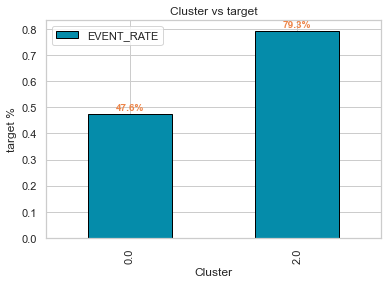

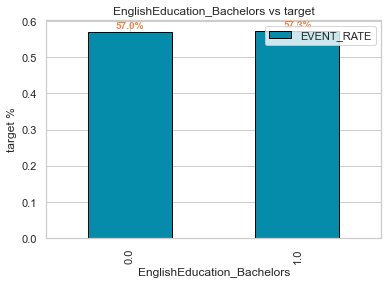

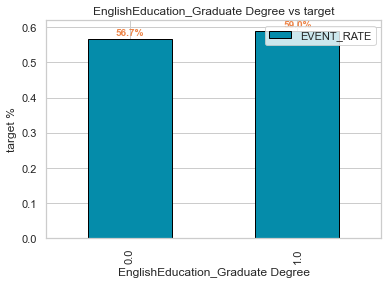

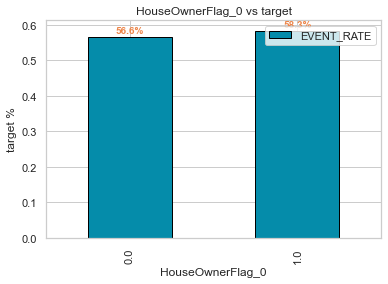

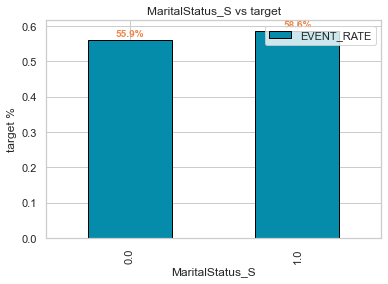

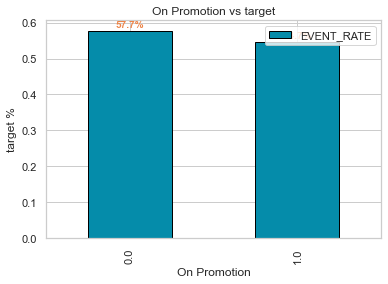

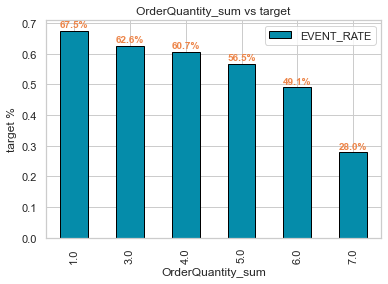

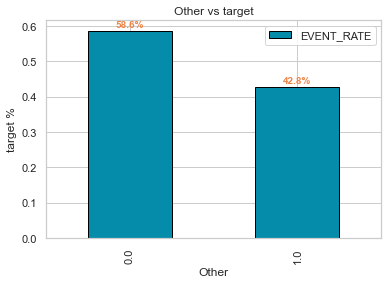

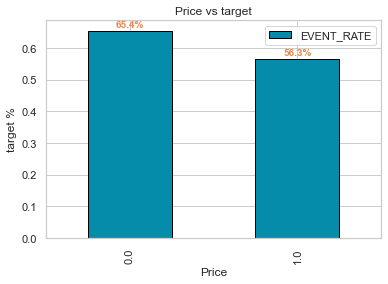

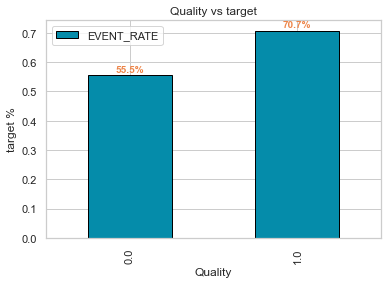

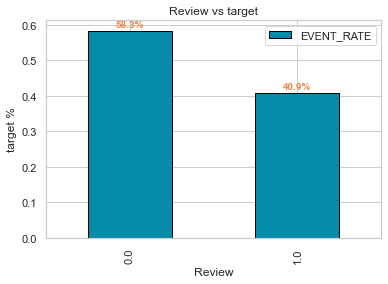

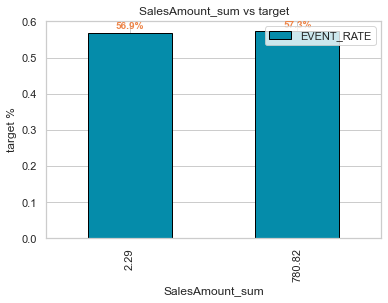

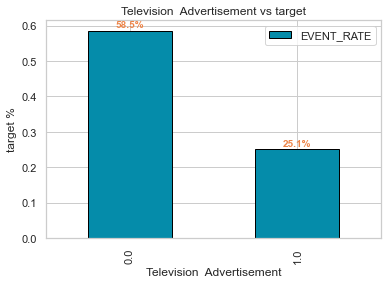

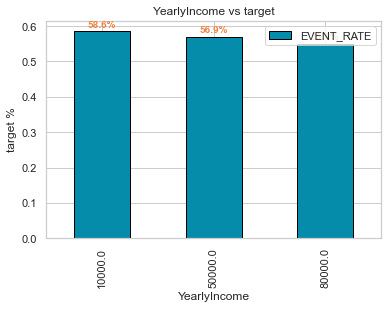

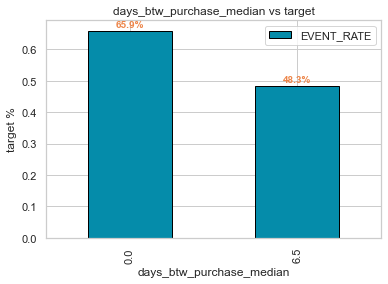

In [136]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['Churn'])
final_iv = final_iv[(final_iv.VAR_NAME != 'Churn')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

Cross Validation

In [137]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size=0.25, random_state=0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']

CV Using RF

In [138]:
#implement cross validation, the cross_val_score method of the sklearn.model_selection library can be used. 
from sklearn.ensemble import RandomForestClassifier  
classifier = RandomForestClassifier(n_estimators=300, random_state=0) 

In [139]:
from sklearn.model_selection import cross_val_score  
all_accuracies = cross_val_score(estimator=classifier, X=features_train, y=label_train, cv=10)  

In [140]:
print(all_accuracies) 

[0.91968254 0.92349206 0.9272785  0.92092728 0.91775167 0.91933947
 0.92757306 0.92153748 0.92566709 0.92439644]


In [141]:
print(all_accuracies.mean())

0.9227645601611816


In [142]:
print(all_accuracies.std()) 

0.0032612087458303934


CV using LR

In [143]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [144]:
all_accuracies = cross_val_score(estimator=clf, X=features_train, y=label_train, cv=10)  

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

In [145]:
print(all_accuracies)

[0.61492063 0.62349206 0.61162274 0.60971737 0.61035249 0.61003493
 0.61467598 0.62325286 0.60578145 0.61753494]


In [146]:
print(all_accuracies.mean()) 

0.61413854660326


In [147]:
print(all_accuracies.std()) 

0.005566740667089943


Grid Search to find the optimal parameters rather than randomly seleting

In [148]:
#https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/
grid_param = {  
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [149]:
from sklearn.model_selection import GridSearchCV
gd_sr = GridSearchCV(estimator=classifier,  
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=10,
                     n_jobs=-1)

Once the GridSearchCV class is initialized, the last step is to call the fit method of the class and pass it the training and 
test set, as shown in the following code:

In [150]:
gd_sr.fit(features_train, label_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'boots

the next step is to check the parameters that return the highest accuracy

In [151]:
best_parameters = gd_sr.best_params_  
print(best_parameters)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 150}


To find the best accuracy achieved, execute the following code:

In [152]:
best_result = gd_sr.best_score_  
print(best_result)

0.9227007113821138


Our Model

In [153]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['Churn']
features_test = test[list(vif['Features'])]
label_test = test['Churn']

In [154]:
all_features = pd.concat([features_train, features_test])
all_labels = pd.concat([label_train, label_test])

In [155]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9725695684966853 0.9096105752054305 0.9971490652400079 0.9539678040233122


In [156]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,10304,484
1,207,14196


In [157]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,6240,978
1,540,9036


LOGISITIC REGRESSION

In [158]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6121630741137708 0.6152197213290461 0.6054297655256646 0.606065868351492


In [159]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,4200,6588
1,3182,11221


In [160]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2824,4394
1,2068,7508


Neural Network

In [161]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.647374062165059 0.6491604144337263 0.6553098063783986 0.6605084250526566


In [162]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,3054,7734
1,1149,13254


In [163]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2089,5129
1,763,8813


Naive Bayes

In [164]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.6275257036243103 0.6301059902346076 0.6410568252077217 0.6413019392713797


In [165]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2123,8665
1,718,13685


In [166]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,1468,5750
1,462,9114


Gradient BoostinG

In [167]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8097336350283831 0.8073716803620341 0.8618828985773187 0.8587736471385353


In [168]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,6832,3956
1,837,13566


In [169]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,4546,2672
1,563,9013


PerforMane TurniniG

In [170]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.9s finished


{'n_estimators': 445, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [171]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**rf_random.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9651065856853638 0.9077051327855187 0.9962856891527898 0.9560056205791101


In [172]:
metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])

(array([0.        , 0.        , 0.        , ..., 0.86624027, 0.86633296,
        1.        ]),
 array([0.        , 0.03061862, 0.03089634, ..., 1.        , 1.        ,
        1.        ]),
 array([2.00000000e+00, 1.00000000e+00, 9.99775281e-01, ...,
        2.04290092e-04, 1.87265918e-04, 0.00000000e+00]))

Final Model and performnce

In [173]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6121630741137708 0.6152197213290461 0.6054297655256646 0.606065868351492


In [174]:
#Train the final model on all the dataset
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(all_features,all_labels)

pred_train = clf.predict(all_features)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,all_labels)


from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(all_labels), clf.predict_proba(all_features)[:,1])
auc_train = metrics.auc(fpr,tpr)


print(accuracy_train,auc_train)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9693938311301655 0.9969177114724913


In [175]:
pd.crosstab(all_labels,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,13169,4837
1,3984,19995


In [176]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,2824,4394
1,2068,7508


In [177]:
import bokeh
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Train data")
r = p.line(fpr,tpr,color='#0077bc',legend = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Loading BokehJS ...

Decile Plots and KS statistic

In [178]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [179]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [180]:
scores_train = scoring(features_train,clf,label_train)
scores_test = scoring(features_test,clf,label_test)

In [181]:
deciling(scores_train,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,2519,2519,0,100,2519,0,17.4894,0,17.4894
2.0,2519,2519,0,100,5038,0,34.9788,0,34.9788
3.0,2519,2519,0,100,7557,0,52.4682,0,52.4682
4.0,2519,2519,0,100,10076,0,69.9576,0,69.9576
5.0,2519,2495,24,99.0472,12571,24,87.2804,0.222469,87.058
6.0,2519,1783,736,70.7821,14354,760,99.6598,7.04486,92.6149
7.0,2519,49,2470,1.94522,14403,3230,100,29.9407,70.0593
8.0,2519,0,2519,0,14403,5749,100,53.2907,46.7093


Lift chart, Actual vs predicted and Gains chart

In [182]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

def plots(agg1,target,type):

    plt.figure(1,figsize=(20, 5))

    plt.subplot(131)
    plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
    plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
    plt.xticks(range(10,110,10))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

    plt.subplot(132)
    X = agg1['DECILE'].tolist()
    X.append(0)
    Y = agg1['DIST_TAR'].tolist()
    Y.append(0)
    plt.plot(sorted(X),sorted(Y))
    plt.plot([0, 100], [0, 100],'r--')
    plt.xticks(range(0,110,10))
    plt.yticks(range(0,110,10))
    plt.grid(True)
    plt.title('Gains Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
    plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
            xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
    plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
            xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

    plt.subplot(133)
    plt.plot(agg1['DECILE'],agg1['LIFT'])
    plt.xticks(range(10,110,10))
    plt.grid(True)
    plt.title('Lift Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel("Lift",fontsize=15)

    plt.tight_layout()

In [183]:
def gains(data,decile_by,target,score):
    inputs = list(decile_by)
    inputs.extend((target,score))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['ACTUAL'] = grouped.mean()[target]*100
    agg1['PRED'] = grouped.mean()[score]*100
    agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
    agg1.index.name = 'DECILE'
    agg1 = agg1.reset_index()
    agg1['DECILE'] = agg1['DECILE']*10
    agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
    plots(agg1,target,'Distribution')

In [184]:
lift_train = pd.concat([features_train,scores_train],axis=1)
lift_test = pd.concat([features_test,scores_test],axis=1)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version


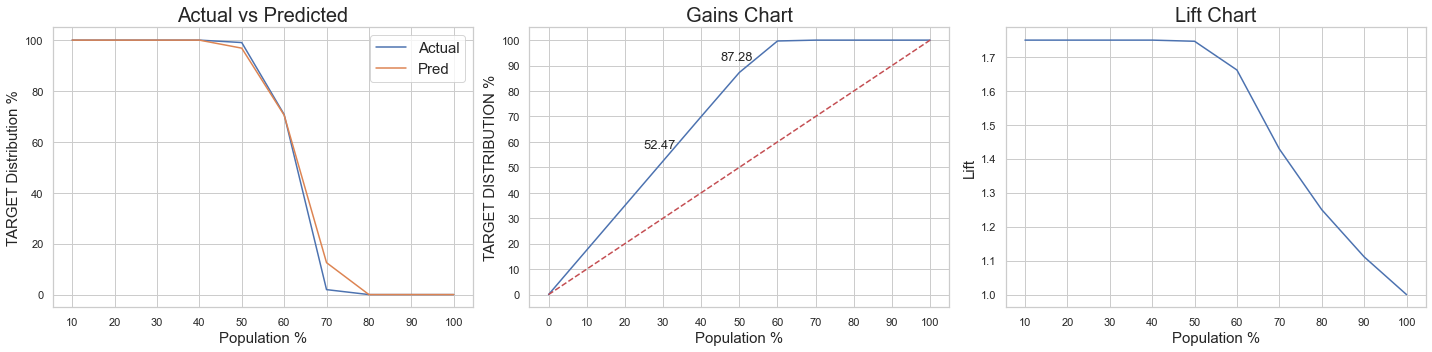

In [185]:
gains(lift_train,['DECILE'],'TARGET','SCORE')

C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version
C:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version


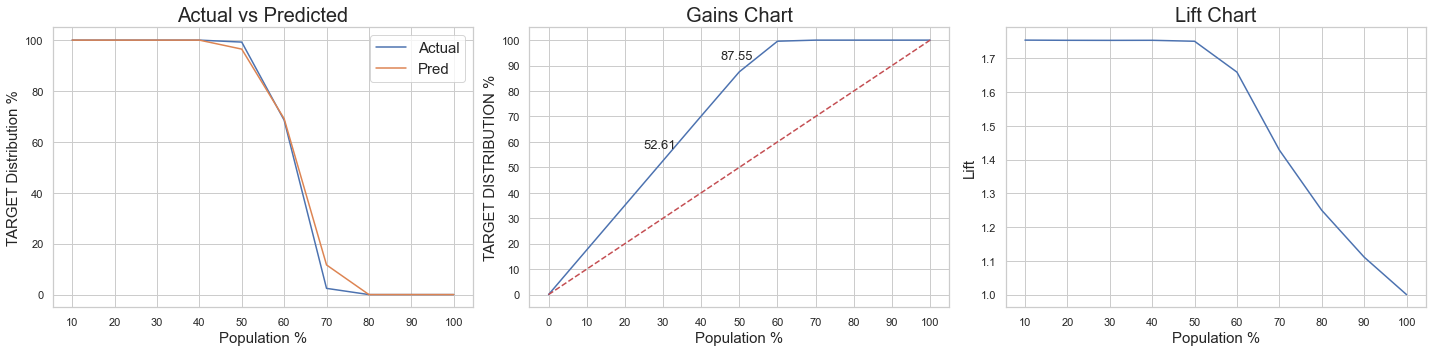

In [186]:
gains(lift_test,['DECILE'],'TARGET','SCORE')

Save Model for future use

In [187]:
import pandas
from sklearn.externals import joblib

filename = 'final_model.model'
i = ['d',clf]
joblib.dump(i,filename)

C:\Users\ThinkPad\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['final_model.model']

New data for model scoring

In [188]:
all_features.dtypes

Cluster                               int64
EnglishEducation_Bachelors            uint8
EnglishEducation_Graduate Degree      uint8
HouseOwnerFlag_0                      uint8
MaritalStatus_S                       uint8
On Promotion                        float64
OrderQuantity_sum                     int64
Other                               float64
Price                               float64
Quality                             float64
Review                              float64
SalesAmount_sum                     float64
Television  Advertisement           float64
YearlyIncome                        float64
days_btw_purchase_median            float64
dtype: object

In [203]:
#Prepare score data to ensure the attributes of the modelling data matches that of the scoring data
#Score_data

#replace missing values with most frequent values
Score_data_sel = Score_data.fillna(Score_data.mode().iloc[0])

#Select features and target
Score_data_sel = Score_data_sel[['Cluster','EnglishEducation_Graduate Degree','HouseOwnerFlag_0',
'MaritalStatus_S',
'On Promotion',
'EnglishEducation_Bachelors',
'NumberCarsOwned',
'OrderQuantity_sum', 'Other','Price',
'Quality',
'Review',
'SalesAmount_sum',
'YearlyIncome',
'days_btw_purchase_median']]

In [204]:
Score_data_sel.head(5)

,Cluster,EnglishEducation_Graduate Degree,HouseOwnerFlag_0,MaritalStatus_S,On Promotion,EnglishEducation_Bachelors,NumberCarsOwned,OrderQuantity_sum,Other,Price,Quality,Review,SalesAmount_sum,YearlyIncome,days_btw_purchase_median
31230,0,0,0,1,0.00,1,4,4,0.00,1.00,0.00,0.00,2379.95,100000.00,0.00
16854,0,0,0,0,0.00,0,3,10,0.00,1.00,1.00,0.00,8451.26,130000.00,60.00
47512,2,0,0,0,0.00,1,1,3,0.00,1.00,0.00,0.00,27.77,60000.00,0.00
51774,0,0,1,1,0.00,1,1,4,0.00,1.00,0.00,0.00,4713.33,60000.00,380.00
3060,0,0,0,0,1.00,1,3,10,0.00,1.00,0.00,0.00,7075.27,170000.00,136.50


In [205]:
# Use the code to load the model
filename = 'final_model.model'

from sklearn.externals import joblib
d,clf=joblib.load(filename)

In [206]:
#Score the final model (Logistic regression) 
pred_train = clf.predict(Score_data_sel)

In [207]:
def score_new(features,clf):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    return(score)

In [208]:
scores = score_new(Score_data_sel,clf)

 How many 0s and 1s are there

In [209]:

print('There are', np.count_nonzero(pred_train == 0), '0s')

print('There are', np.count_nonzero(pred_train == 1), '1s')

There are 13036 0s
There are 4969 1s


In [210]:
Score_data.head(5)

,CustomerKey,SalesAmount_sum,SalesAmount_max,SalesAmount_min,SalesAmount_mean,SalesAmount_median,OrderQuantity_sum,OrderQuantity_max,OrderQuantity_min,OrderQuantity_mean,...,EnglishOccupation_Manual,EnglishOccupation_Professional,EnglishOccupation_Skilled Manual,HouseOwnerFlag_0,HouseOwnerFlag_1,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles
31230,18518,2379.95,2379.95,2379.95,2379.95,2379.95,4,4,4,4.00,...,0,0,0,0,1,0,0,0,1,0
16854,14427,8451.26,3578.27,2398.05,2817.09,2474.94,10,6,1,3.33,...,0,1,0,0,1,0,0,0,0,1
47512,24373,27.77,27.77,27.77,27.77,27.77,3,3,3,3.00,...,0,1,0,0,1,0,0,0,1,0
51774,26014,4713.33,3399.99,1313.34,2356.66,2356.66,4,3,1,2.00,...,0,1,0,1,0,1,0,0,0,0
3060,11422,7075.27,3399.99,562.96,1768.82,1556.16,10,4,1,2.50,...,0,0,0,0,1,0,0,0,0,1


In [211]:
# Put the result in a dataframe

#pd.DataFrame({'Customer_ID':non_churners_score.Customer_ID,'Churn_Flag':DecTree_score_pred}).to_csv('Predicted Churners.csv',index=False)
# Store the result in a csv file
#, 'Score':scores.SCORE, 'Decile':scores.DECILE
Final = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Churn_Flag':pred_train})

In [212]:
Final.head()

,CustomerKey,Churn_Flag
31230,18518,1
16854,14427,1
47512,24373,1
51774,26014,0
3060,11422,0


Merge the Final data to the custtbl to do some demographics profiling

In [214]:
Final_ouput = pd.merge(df_customer,
                 Final,
                 on='CustomerKey',how = 'inner')
Final_ouput.tail()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Cluster,Churn_Flag
115757,29471,1965-09-23,S,F,10000.00,1,1,High School,Manual,0,1,2014-01-21,2-5 Miles,1,0
115758,29471,1965-09-23,S,F,10000.00,1,1,High School,Manual,0,1,2014-01-21,2-5 Miles,1,0
115759,29472,1965-09-11,M,F,10000.00,1,1,High School,Manual,0,1,2013-09-01,1-2 Miles,2,1
115760,29472,1965-09-11,M,F,10000.00,1,1,High School,Manual,0,1,2013-09-01,1-2 Miles,2,1
115761,29472,1965-09-11,M,F,10000.00,1,1,High School,Manual,0,1,2013-09-01,1-2 Miles,2,1


In [215]:
Final_ouput.count()

CustomerKey             115762
BirthDate               115762
MaritalStatus           115762
Gender                  115762
YearlyIncome            115762
TotalChildren           115762
NumberChildrenAtHome    115762
EnglishEducation        115762
EnglishOccupation       115762
HouseOwnerFlag          115762
NumberCarsOwned         115762
DateFirstPurchase       115762
CommuteDistance         115762
Cluster                 115762
Churn_Flag              115762
dtype: int64

In [216]:
#scores.count()
#pred_train.count()
#Score_data.CustomerKey.count()
#Final.head(5)
#clf.predict_proba(features)
#clf.predict_proba(features)[:,1]
prob = scores[['SCORE']].values.squeeze()

In [217]:
prob

array([0.6 , 0.7 , 0.78, ..., 0.5 , 0.2 , 0.55])

In [218]:
Final_ = pd.DataFrame({'CustomerKey':Score_data.CustomerKey,'Churn_Probability':prob})

In [219]:
Final_.head(5)

,CustomerKey,Churn_Probability
31230,18518,0.60
16854,14427,0.70
47512,24373,0.78
51774,26014,0.40
3060,11422,0.40


Merge the probabilities to the

In [225]:
Final = pd.merge(Final_ouput,
                 Final_,
                 on='CustomerKey',how = 'inner')
Final.tail()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Cluster,Churn_Flag,Churn_Probability
1215929,29471,1965-09-23,S,F,10000.00,1,1,High School,Manual,0,1,2014-01-21,2-5 Miles,1,0,0.40
1215930,29471,1965-09-23,S,F,10000.00,1,1,High School,Manual,0,1,2014-01-21,2-5 Miles,1,0,0.40
1215931,29472,1965-09-11,M,F,10000.00,1,1,High School,Manual,0,1,2013-09-01,1-2 Miles,2,1,0.84
1215932,29472,1965-09-11,M,F,10000.00,1,1,High School,Manual,0,1,2013-09-01,1-2 Miles,2,1,0.84
1215933,29472,1965-09-11,M,F,10000.00,1,1,High School,Manual,0,1,2013-09-01,1-2 Miles,2,1,0.84


In [226]:
high_prob=Final[Final.Churn_Probability>=0.70]

In [286]:
high_prob['CustomerKey'].agg(['count','nunique'])

count      21220
nunique     1870
Name: CustomerKey, dtype: int64

In [227]:
high_prob.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance,Cluster,Churn_Flag,Churn_Probability
11067,11043,1981-08-23,M,M,60000.00,0,0,Partial College,Skilled Manual,1,2,2013-05-08,5-10 Miles,2,1,0.80
11068,11043,1981-08-23,M,M,60000.00,0,0,Partial College,Skilled Manual,1,2,2013-05-08,5-10 Miles,2,1,0.80
11069,11043,1981-08-23,M,M,60000.00,0,0,Partial College,Skilled Manual,1,2,2013-05-08,5-10 Miles,2,1,0.80
11070,11043,1981-08-23,M,M,60000.00,0,0,Partial College,Skilled Manual,1,2,2013-05-08,5-10 Miles,2,1,0.80
11071,11043,1981-08-23,M,M,60000.00,0,0,Partial College,Skilled Manual,1,2,2013-05-08,5-10 Miles,2,1,0.80


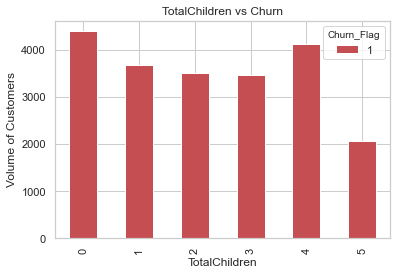

In [255]:
pd.crosstab(high_prob.TotalChildren,high_prob.Churn_Flag).plot(kind='bar', color='r')
plt.title('TotalChildren vs Churn')
plt.xlabel('TotalChildren')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

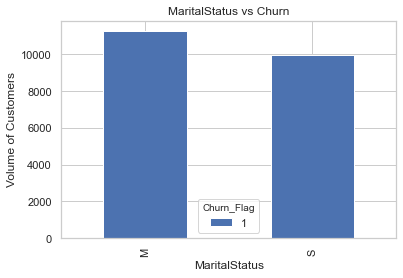

In [266]:
pd.crosstab(high_prob.MaritalStatus,high_prob.Churn_Flag).plot(kind='bar')
plt.title('MaritalStatus vs Churn')
plt.xlabel('MaritalStatus')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

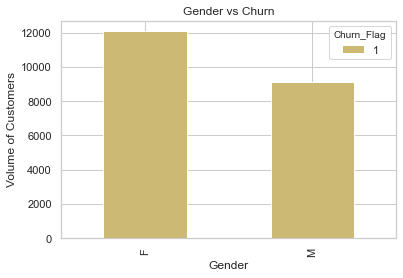

In [257]:
pd.crosstab(high_prob.Gender,high_prob.Churn_Flag).plot(kind='bar', color='y')
plt.title('Gender vs Churn')
plt.xlabel('Gender')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

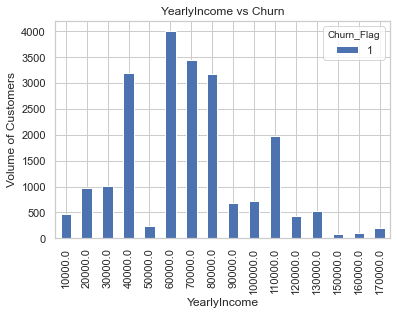

In [234]:
pd.crosstab(high_prob.YearlyIncome,high_prob.Churn_Flag).plot(kind='bar')
plt.title('YearlyIncome vs Churn')
plt.xlabel('YearlyIncome')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

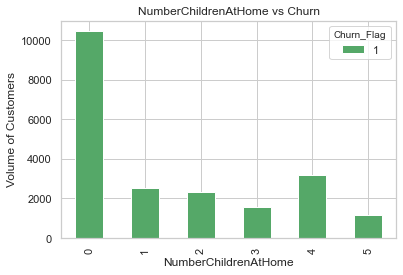

In [268]:
pd.crosstab(high_prob.NumberChildrenAtHome,high_prob.Churn_Flag).plot(kind='bar',color='g')
plt.title('NumberChildrenAtHome vs Churn')
plt.xlabel('NumberChildrenAtHome')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

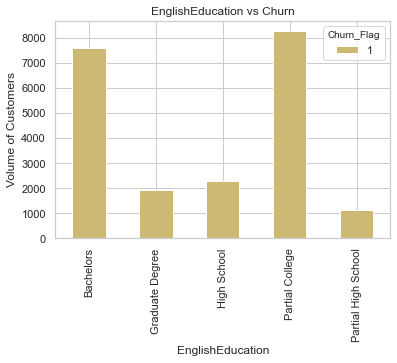

In [260]:
pd.crosstab(high_prob.EnglishEducation,high_prob.Churn_Flag).plot(kind='bar',color='y')
plt.title('EnglishEducation vs Churn')
plt.xlabel('EnglishEducation')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

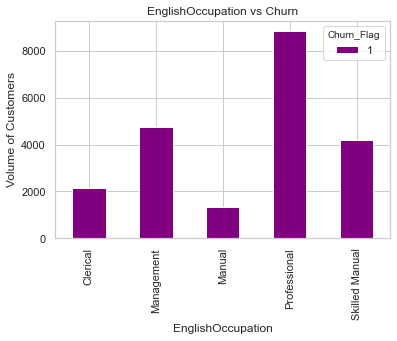

In [261]:
pd.crosstab(high_prob.EnglishOccupation,high_prob.Churn_Flag).plot(kind='bar',color='purple')
plt.title('EnglishOccupation vs Churn')
plt.xlabel('EnglishOccupation')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

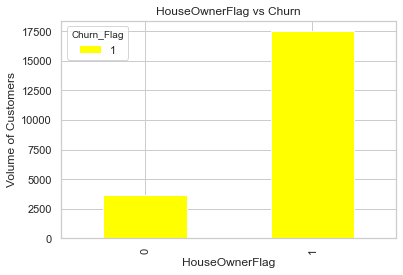

In [262]:
pd.crosstab(high_prob.HouseOwnerFlag,high_prob.Churn_Flag).plot(kind='bar',color='Yellow')
plt.title('HouseOwnerFlag vs Churn')
plt.xlabel('HouseOwnerFlag')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

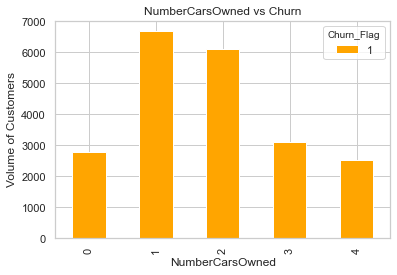

In [263]:
pd.crosstab(high_prob.NumberCarsOwned,high_prob.Churn_Flag).plot(kind='bar',color='Orange')
plt.title('NumberCarsOwned vs Churn')
plt.xlabel('NumberCarsOwned')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

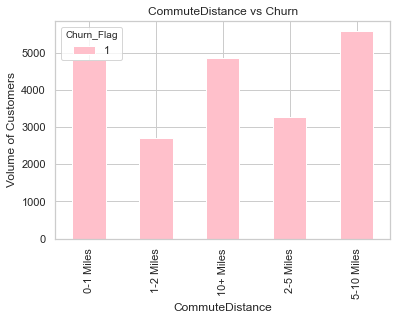

In [273]:
pd.crosstab(high_prob.CommuteDistance,high_prob.Churn_Flag).plot(kind='bar', color='pink')
plt.title('CommuteDistance vs Churn')
plt.xlabel('CommuteDistance')
plt.ylabel('Volume of Customers')
plt.savefig('pur_fre_pout_bar')

In [224]:
Final.to_csv('Churners_Outcome.csv')
# create plots filter for churn prob 0.7
#capture new behaviours on a timely manner
#software lifecycle - test enviroment , uat review the tool, migrate to production enviroment parrallel with live reports